# Problem Set 7A

## 1. Wealth Game of Hang Seng Index 
Write a Python program modeling 𝑁  =  101 agents using Wealth Game strategies and payoffs to invest 
in the time series of Hang Seng Index. Fix the memory size 𝑀 = 3. Below are the suggested logical steps:
### (1) Download the time series of Hang Seng Index from 21 November 2021 to 21 November 2022, 
as it was done in Problem Set 5A. This will form the time series of the prices 𝑃(𝑡).

In [1]:
import pandas as pd
import numpy as np
from itertools import product
from IPython.display import Markdown
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("data/^HSI.csv")
df.dropna(inplace=True)
P = df["Adj Close"].to_numpy()

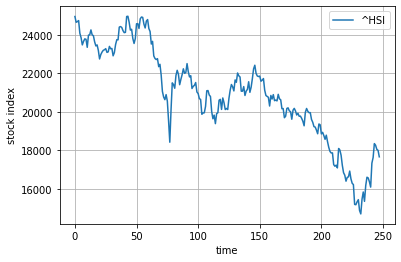

In [3]:
plt.plot(P,label='^HSI')
plt.xlabel("time")
plt.ylabel("stock index")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
beta = 0.5
T = len(P)
PT = np.zeros_like(P)
PT[1:] = P[:-1] + beta * (P[1:]-P[:-1])
b = np.zeros_like(P,dtype=int)
b[:-1] = (P[1:]>P[:-1])
mu = np.zeros_like(P,dtype=int)
for t in range(T-1):
    mu[t+1]=(2*mu[t]+b[t])%8

In [7]:
def simu_strategy(M=3):
    T = len(P)
    strategies = np.array(list(product((-1, 1), repeat=2**M)))
    N = len(strategies)
    vwealth = np.zeros((N, T))
    vwealth[:, 0] = 5*P[0]
    vposition = np.zeros((N, T))
    vdecision = np.zeros(N)
    for t in range(T-1):
        vdecision = strategies[:, mu[t]]
        vposition[:, t+1] = np.maximum(np.minimum(vposition[:, t] + vdecision,
                                                  vwealth[:, t] / P[t]), -vwealth[:, t] / P[t])
        vwealth[:, t+1] = vwealth[:, t]+vposition[:, t]*(PT[t+1]-PT[t])
    return vwealth


def choose_strategy(vscores, strategies):
    N = vscores.shape[0]
    M = strategies.shape[2]
    chosen = np.empty((N, M), dtype=int)
    for i in range(N):
        maxv = np.max(vscores[i])
        idx = np.random.choice(np.argwhere(vscores[i] == maxv).T[0])
        chosen[i] = strategies[i, idx]
    return chosen


def wealth_game(N=101, m=3, S=2, seed=5003):
    T = len(P)
    np.random.seed(seed)
    M = 2**m
    # init strategies of all agents
    strategies = 2*np.random.randint(2, size=(N, S, M))-1
    # init virtual wealth
    vwealth = np.zeros((N, S, T))
    vwealth[:, :, 0] = 5*P[0]
    # init virtual position
    vposition = np.zeros((N, S, T))
    # init real wealth
    rwealth = np.zeros((N, T))
    rwealth[:, 0] = 5*P[0]
    # init real position
    rposition = np.zeros((N, T))
    for t in range(T-1):
        # agents choose the strategy with higher virtual wealth randomly
        chosen_stgs = choose_strategy(vwealth, strategies)
        # agents make decisions
        rdecision = chosen_stgs[:, mu[t]]
        # strategies make decision
        vdecision = strategies[:, :, mu[t]]
        # update virtual things
        vposition[..., t+1] = np.maximum(np.minimum(vposition[..., t] + vdecision,
                                                    vwealth[..., t] / P[t]), -vwealth[..., t] / P[t])
        vwealth[..., t+1] = vwealth[..., t]+vposition[..., t]*(PT[t+1]-PT[t])
        # update real things
        rposition[:, t+1] = np.maximum(np.minimum(rposition[:, t] + rdecision,
                                                  rwealth[:, t] / P[t]), -rwealth[:, t] / P[t])
        rwealth[:, t+1] = rwealth[:, t]+rposition[:, t]*(PT[t+1]-PT[t])
    return rwealth


### (12)Calculate the best, worst, and average virtual wealth of the strategies at the end of the game. Then 
calculate the best, worst, and average real wealth of the agents at the end of the game. To facilitate 
a better interpretation of your results, divide your results by the initial price.

In [8]:
vwealth = simu_strategy()
rwealth = wealth_game()

In [9]:
best_vwealth = np.max(vwealth[:,-1])/P[0]
worst_vwealth = np.min(vwealth[:,-1])/P[0]
average_vwealth = np.mean(vwealth[:,-1])/P[0]
best_rwealth = np.max(rwealth[:,-1])/P[0]
worst_rwealth = np.min(rwealth[:,-1])/P[0]
average_rwealth = np.mean(rwealth[:,-1])/P[0]
Markdown(f"""
|                | best | worst | average |
| -------------- | ---- | ----- | ------- |
| virtual wealth |{best_vwealth}|{worst_vwealth}|{average_vwealth}|
| real wealth    |{best_rwealth}|{worst_rwealth}|{average_rwealth}|
""")


|                | best | worst | average |
| -------------- | ---- | ----- | ------- |
| virtual wealth |6.509489730585201|3.4895242495602465|4.965784654326929|
| real wealth    |6.30151073256469|3.541040080565193|5.15356802583995|


### (13)Find the best 3 and worst 3 strategies and plot a graph of their virtual wealth as a function of time. 
For comparison, also plot the stock index multiplied by 5.

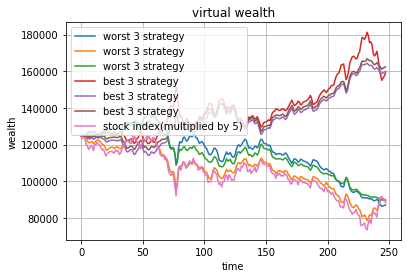

In [10]:
sorted_vwealth = vwealth[np.argsort(vwealth[:,-1])]
plt.plot(sorted_vwealth[:3].T,label="worst 3 strategy")
plt.plot(sorted_vwealth[-3:].T,label="best 3 strategy")
plt.plot(5*P,label="stock index(multiplied by 5)")
plt.grid(True)
plt.legend()
plt.xlabel("time")
plt.ylabel("wealth")
plt.title("virtual wealth")
plt.show()

### (14)Find  the  best  3  and  worst  3  agents  and  plot  a  graph  of  their  real  wealth  as  a  function  of  time.  For 
comparison, also plot the stock index multiplied by 5.

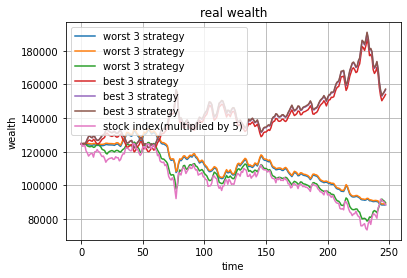

In [11]:
sorted_rwealth = rwealth[np.argsort(rwealth[:,-1])]
plt.plot(sorted_rwealth[:3].T,label="worst 3 strategy")
plt.plot(sorted_rwealth[-3:].T,label="best 3 strategy")
plt.plot(5*P,label="stock index(multiplied by 5)")
plt.grid(True)
plt.legend()
plt.xlabel("time")
plt.ylabel("wealth")
plt.title("real wealth")
plt.show()

### (15)Write down some observations of the strategies and the agents. This is an open-ended question and 
I encourage you to have some analysis. For example, what makes a strategy a winning or losing one, 
if  any?  Are  there  any  need  for  an  agent  to  change  strategy  when  the  environment  changes?  What 
strategy/agent is good when the price has a trend? What strategy/agent is good when the price trend 
is rugged? Etc.